In [1]:
import json
import glob
import itertools

import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp


import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

In [2]:
from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

In [3]:
from qiskit_aer.primitives import Estimator as AerEstimator

from pprint import pprint

In [4]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)


### Load data

In [5]:
depths = list(range(1, 10))

all_paths = {}
for depth in depths:
    all_paths[depth] = glob.glob(f"./data/uniform_distr_dataset/post_transpilation_depth/5_qubits/pyg_data/{depth}_**.json")

train_paths = []
val_paths = []
test_paths = []

for i, (depth, paths) in enumerate(all_paths.items()):
    train_paths += paths[:12]
    val_paths += paths[12:16]
    test_paths += paths[16:]

len(train_paths), len(val_paths), len(test_paths)

(108, 36, 36)

In [6]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[790, 28], edge_index=[2, 1722], edge_attr=[932, 3], y=[32, 1], observable=[32, 1, 21], circuit_depth=[32, 1], noisy_0=[32, 1], noisy_1=[32, 1], batch=[790], ptr=[33])


In [7]:
# define model

In [8]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        n_qubits: int,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        
        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)
        
        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 2, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)    
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )
        
        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )
        
        graph = global_mean_pool(graph, batch)
    
        merge = torch.cat((
            graph, 
            exp_value,
            circuit_depth
        ), dim=1)

        return self.body_seq(merge)

In [9]:
model = ExpValCircuitGraphModel(
    n_qubits=5,
    num_node_features=28, 
    hidden_channels=20
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.00001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.5, 
                              patience=20, 
                              verbose=True, 
                              min_lr=0.00001)

In [13]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

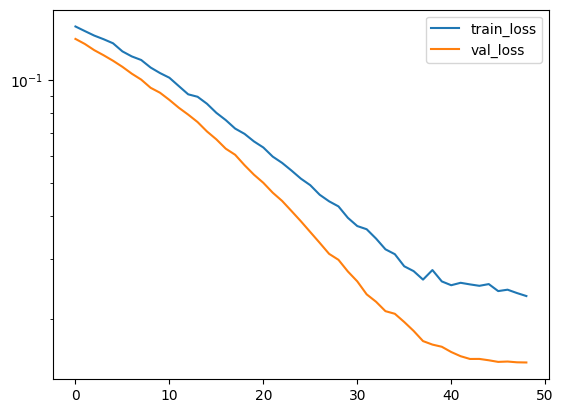

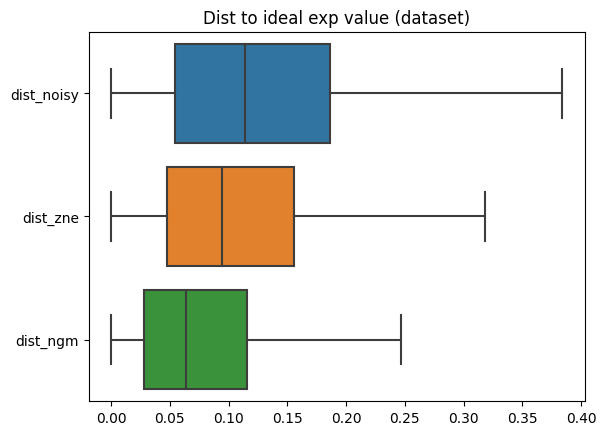

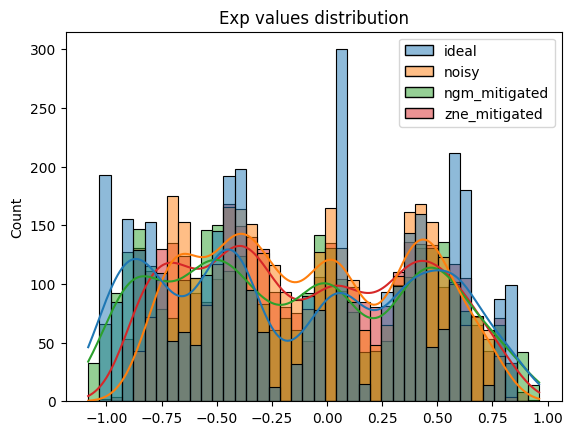

In [14]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, zne_mitigated, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        data.noisy_1.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        zne_mitigated = np.mean(zne_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "zne_mitigated": zne_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
            "dist_zne": np.abs(ideal - zne_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_zne", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value (dataset)")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"], df["zne_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [15]:
all_report_data = []

ngem_improvement_factors = {}
zne_improvement_factors = {}

ideal_means = []
noisy_means = []
ngem_mitigated_means = []
zne_mitigated_means = []

for depth, paths in tqdm_notebook(list(all_paths.items())):
    test_paths = paths[16:]
        
    if len(test_paths) == 0: continue
    
    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    ngem_problems = []
    zne_problems = []

    ideal_values = []
    ngem_values = []
    zne_values = []
    noisy_valuses = []
    
    for i, data in enumerate(test_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)

        for ideal, noisy, zne_mitigated, ngm_mitigated in zip(
            data.y.tolist(),
            data.noisy_0.tolist(),
            data.noisy_1.tolist(),
            out.tolist()
        ):
            ngem_problem = Problem(
                trials=[Trial(noisy=noisy[0], mitigated=ngm_mitigated[0])],
                ideal_exp_value=ideal[0]
            )
            ngem_problems.append(ngem_problem)
            
            zne_problem = Problem(
                trials=[Trial(noisy=noisy[0], mitigated=zne_mitigated[0])],
                ideal_exp_value=ideal[0]
            )
            zne_problems.append(zne_problem)
            
            ideal_values.append(ideal[0])
            ngem_values.append(np.abs(ideal[0] - ngm_mitigated[0]))
            noisy_valuses.append(np.abs(ideal[0] - noisy[0]))
            zne_values.append(np.abs(ideal[0] - zne_mitigated[0]))

            all_report_data.append({
                "ideal": ideal[0],
                "ngem": ngm_mitigated[0],
                "zne": zne_mitigated[0],
                "noisy": noisy[0],
                "depth": depth
            })

    ideal_means.append(np.average(ideal_values))
    noisy_means.append(np.average(noisy_valuses))
    ngem_mitigated_means.append(np.average(ngem_values))
    zne_mitigated_means.append(np.average(zne_values))    

    ngem_improvement_factors[depth] = improvement_factor(ngem_problems, 1, 1)
    zne_improvement_factors[depth] = improvement_factor(zne_problems, 1, 2)

  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
df = pd.DataFrame(all_report_data)
df.head()

,ideal,ngem,zne,noisy,depth
0,0.316406,0.305969,0.40625,0.2655,1
1,0.285156,0.325973,0.24550,0.2855,1
2,0.341797,0.408584,0.24625,0.3400,1
3,0.341797,0.384445,0.24025,0.3545,1
4,0.294922,0.339571,0.35900,0.3065,1


#### Plot improvement factors

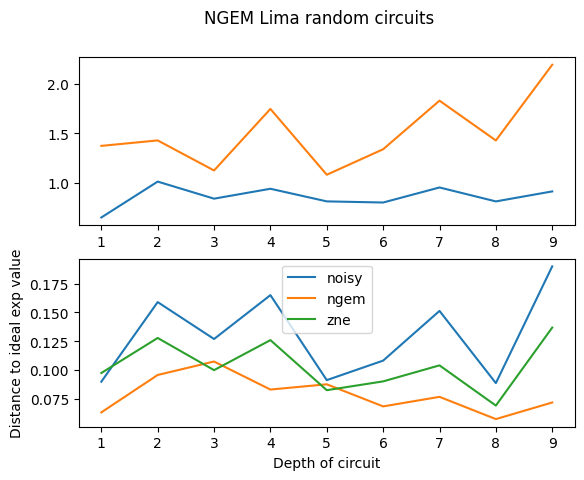

In [17]:
kwargs = {"capsize": 10, "lw": 2}

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('NGEM Lima random circuits')

dapth_data = [k for k, v in list(all_paths.items())[:10] if len(v) > 0]

ax1.plot(dapth_data, zne_improvement_factors.values(), label="zne")
ax1.plot(dapth_data, ngem_improvement_factors.values(), label="ngem")

ax2.plot(dapth_data, noisy_means, label="noisy")
ax2.plot(dapth_data, ngem_mitigated_means, label="ngem")
ax2.plot(dapth_data, zne_mitigated_means, label="zne")

plt.xlabel("Depth of circuit")
plt.ylabel("Distance to ideal exp value")
plt.legend()
plt.show()

In [18]:
df["dist_noisy"] = np.abs(df["ideal"] - df["noisy"])
df["dist_zne"] = np.abs(df["ideal"] - df["zne"])
df["dist_ngem"] = np.abs(df["ideal"] - df["ngem"])

df["bias_noisy"] = df["ideal"] - df["noisy"]
df["bias_zne"] = df["ideal"] - df["zne"]
df["bias_ngem"] = df["ideal"] - df["ngem"]

In [19]:
dapth_data = []
zne_bias = []
zne_dist = []
zne_variance = []
ngem_bias = []
ngem_dist = []
ngem_variance = []
noisy_bias = []
noisy_dist = []
for depth in df['depth'].unique():
    dapth_data.append(depth)
    
    noisy_bias.append(np.mean(df[df['depth'] == depth]['bias_noisy']))
    noisy_dist.append(np.mean(df[df['depth'] == depth]['dist_noisy']))

    ngem_bias.append(np.mean(df[df['depth'] == depth]['bias_ngem']))
    ngem_dist.append(np.mean(df[df['depth'] == depth]['dist_ngem']))
    ngem_variance.append(np.var(df[df['depth'] == depth]['dist_ngem']))
    
    zne_bias.append(np.mean(df[df['depth'] == depth]['bias_zne']))
    zne_dist.append(np.mean(df[df['depth'] == depth]['dist_zne']))
    zne_variance.append(np.var(df[df['depth'] == depth]['dist_zne']))

#### Distance plot

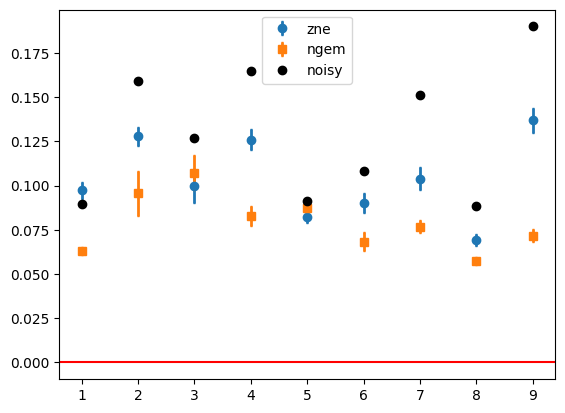

In [20]:
kwargs = {"capsize": 1, "lw": 2}

plt.errorbar(dapth_data, 
             zne_dist, 
             yerr=zne_variance, 
             label="zne", 
             fmt='o',
             **kwargs)
plt.errorbar(dapth_data, 
             ngem_dist, 
             yerr=ngem_variance, 
             label="ngem", 
             fmt='s',
             **kwargs)
plt.errorbar(dapth_data, 
             noisy_dist, 
             label="noisy", 
             fmt='o',
             color='black',
             **kwargs)
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.show()

#### Bias plot

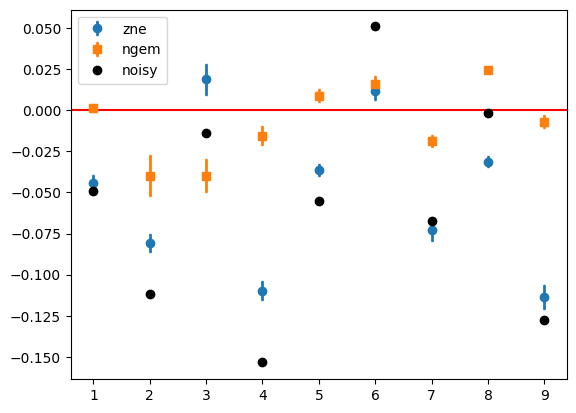

In [21]:
kwargs = {"capsize": 1, "lw": 2}

plt.errorbar(dapth_data, 
             zne_bias, 
             yerr=zne_variance, 
             label="zne", 
             fmt='o',
             **kwargs)
plt.errorbar(dapth_data, 
             ngem_bias, 
             yerr=ngem_variance, 
             label="ngem", 
             fmt='s',
             **kwargs)
plt.errorbar(dapth_data, 
             noisy_bias, 
             label="noisy", 
             fmt='o',
             color='black',
             **kwargs)
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.show()

#### Distribution plot

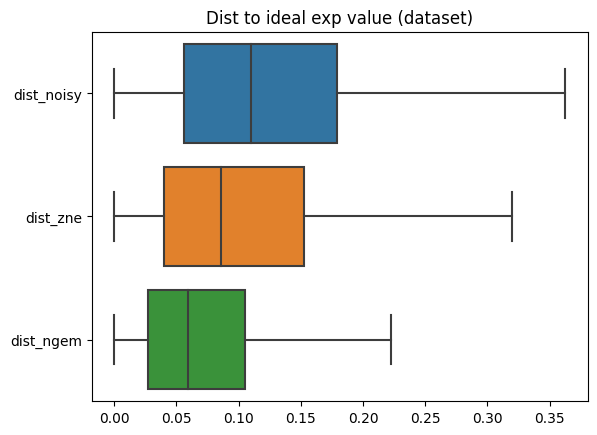

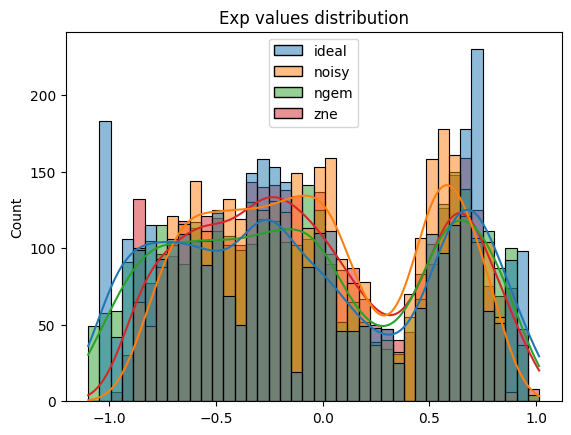

In [22]:
sns.boxplot(data=df[["dist_noisy", "dist_zne", "dist_ngem"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value (dataset)")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngem"], df["zne"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

plt.show()

In [32]:
df[["ideal", "ngem", "zne", "noisy", "depth"]].to_csv("./results/real_device.csv")